# Kaggle Hacker News Posts 과제


1.   영어 데이터셋 전처리 및 토크나이징
2.   PMI Matrix 생성 및 유사도 확인
3.   빈도에 따라 워드 클라우드 생성



**Dataset** 
* https://www.kaggle.com/hacker-news/hacker-news-posts
* This data set is Hacker News posts from the last 12 months (up to September 26 2016).

**참고 Notebook**
* https://www.kaggle.com/alexklibisz/simple-word-vectors-with-co-occurrence-pmi-and-svd

In [3]:
!pip install kaggle

**kaggle json 활용법**

https://medium.com/hyunjulie/%EC%BA%90%EA%B8%80%EA%B3%BC-%EA%B5%AC%EA%B8%80-colab-%EC%97%B0%EA%B2%B0%ED%95%B4%EC%A3%BC%EA%B8%B0-6a274f6de81d

In [4]:
# kaggle 사이트에서 다운받은 json 파일 업로드

from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"honghyeong","key":"b84b666e82cd1f1cd5b15e0741680806"}'}

In [5]:
ls -lha kaggle.json # 실행시 방금 업로드한 json 파일의 이름이 나온다면 성공.

-rw-r--r-- 1 root root 66 Jul 26 13:24 kaggle.json


In [6]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/kaggle.json

# permission warning 방지
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
# 본인이 참가한 모든 대회 보기
!kaggle competitions list 

ref                                                  deadline             category            reward  teamCount  userHasEntered  
---------------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
contradictory-my-dear-watson                         2030-07-01 23:59:00  Getting Started     Prizes        231           False  
gan-getting-started                                  2030-07-01 23:59:00  Getting Started     Prizes        392           False  
tpu-getting-started                                  2030-06-03 23:59:00  Getting Started  Knowledge       1029           False  
digit-recognizer                                     2030-01-01 00:00:00  Getting Started  Knowledge       6688           False  
titanic                                              2030-01-01 00:00:00  Getting Started  Knowledge      57097            True  
house-prices-advanced-regression-techniques          2030-01-01 00:00:00  Getting Started 

In [8]:
!kaggle datasets download -d hacker-news/hacker-news-posts

 47% 9.00M/19.0M [00:00<00:00, 42.5MB/s]
100% 19.0M/19.0M [00:00<00:00, 63.3MB/s]


In [9]:
!ls

hacker-news-posts.zip  kaggle.json  sample_data


In [10]:
!unzip /content/hacker-news-posts.zip

Archive:  /content/hacker-news-posts.zip
  inflating: HN_posts_year_to_Sep_26_2016.csv  


# 1. Data Preparation

In [11]:
from __future__ import print_function, division # python 2에서 가능한 기능을 python3에서도 가능하게 만들어줌.
from collections import Counter
from itertools import combinations
from math import log
from pprint import pformat
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import svds
from string import punctuation
from time import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import nltk # 자연어 처리를 위한 패키지.
nltk.download('stopwords')
from nltk.corpus import stopwords 
import string
print('Ready')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
Ready


In [12]:
df=pd.read_csv('/content/HN_posts_year_to_Sep_26_2016.csv',usecols=['title']) # 기사 제목만 사용할 것
df.head()

,title
0,You have two days to comment if you want stem ...
1,SQLAR the SQLite Archiver
2,What if we just printed a flatscreen televisio...
3,algorithmic music
4,How the Data Vault Enables the Next-Gen Data W...


# 2. Data Preprocessing

* 소문자
* accent 문자 제거
* 특수문자 제거
* 불용어 제거

In [13]:
# import string
# import nltk
# nltk.download('stopwords')
# from nltk.corpus import stopwords

def preprocess(x):
  sent=x.lower() # 소문자 변환
  sent=sent.encode('ascii','ignore').decode() # accent 된 문자가 들어가는 경우 제외 (영어 문자만 취급)
  sent=''.join([c for c in sent if c not in string.punctuation]) # 특수문자, 부호 제외하고, 문장별 단어리스트 생성
  sent=[word for word in sent.split() if word not in stopwords_set] # 불용어 제거
  return sent

stopwords_set=set(stopwords.words('english'))
preprocessed=df['title'].apply(preprocess) # df.apply : 행/열/전체원소에 대해 원하는 함수 지원
print(preprocessed[:10]) 

0    [two, days, comment, want, stem, cells, classi...
1                            [sqlar, sqlite, archiver]
2       [printed, flatscreen, television, side, boxes]
3                                 [algorithmic, music]
4    [data, vault, enables, nextgen, data, warehous...
5                           [saving, hassle, shopping]
6    [macalifa, new, opensource, music, app, uwp, w...
7    [github, theweavrsmacalifa, music, player, wri...
8                    [google, allo, first, impression]
9         [advanced, multimedia, linux, command, line]
Name: title, dtype: object


In [14]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [15]:
# sent='hello my world!'
# sent=''.join([c for c in sent if c not in string.punctuation])
# print(sent)

# 3. N-gram count(단어 빈도 카운트)

동시발생행렬은 너무 거대한 행렬이 생기므로, 컴퓨팅 자원이 부족함.

Unigram and Bigram Count
* n-gram : n개의 연속적인 단어 나열을 의미 

An adorable little boy is spreading smiles 라는 문장에 대해서

* unigrams : and, adorable, little, boy, is, spreading, smiles
* bigram : an adorable, adorable little, little boy, boy is, is spreading, spreading smiles

In [16]:
# from collections import Counter
# form itertools import combinations : 리스트 원소들의 조합 count 후 튜플 리스트로 리턴.

In [25]:
unigram =Counter() # 한 단어의 빈도수
bigram=Counter() # 두 단어 조합의 빈도수

for sent in preprocessed:
  for word in sent: # unigram
    unigram[word]+=1
  for w1,w2 in map(sorted,combinations(sent,2)): # bigram count (같은 단어의 쌍도 포함) ??
    bigram[(w1,w2)]+=1

**고빈도, 저빈도 단어 제거**

In [26]:
print('전체 코퍼스 수 : '+str(len(unigram)))

전체 코퍼스 수 : 99044


In [27]:
len(df)

293119

In [28]:
min_count=(1/1000)*len(df) # 전체 문장 (293119 중 0.001 = 293번 이하로 등장하는 단어 (저빈도 단어) 제거)
max_count=(1/50)*len(df)  # 전체 문장의 반 이상 등장하는 단어(고빈도 단어) 제거

for word in list(unigram.keys()): # 단어 리스트
  if unigram[word] < min_count or unigram[word] > max_count:
    del unigram[word]

print('제거 후 전체 코퍼스 수 : '+str(len(unigram)))
print('Most Common : ',unigram.most_common()[:25])

제거 후 전체 코퍼스 수 : 972
Most Common :  [('google', 5532), ('app', 5124), ('using', 4613), ('us', 4189), ('web', 4134), ('startup', 3849), ('open', 3828), ('first', 3730), ('code', 3705), ('apple', 3695), ('pdf', 3659), ('software', 3558), ('video', 3462), ('tech', 3410), ('free', 3180), ('2016', 3108), ('use', 3100), ('learning', 3092), ('time', 2934), ('facebook', 2853), ('go', 2836), ('get', 2766), ('one', 2764), ('make', 2751), ('world', 2712)]


In [29]:
# Bigram에서도 제거 
for w1, w2 in list(bigram.keys()):
  if w1 not in unigram or w2 not in unigram:
    del bigram[(w1,w2)]

# 4. 단어 간 관련도 계산 - PMI Matrix 생성

In [30]:
word_to_id, id_to_word={},{}

for id, word in enumerate(unigram.keys()):
  word_to_id[word]=id
  id_to_word[id]=word


PMI Matrix (개별 단어의 빈도가 고려된 동시발생 행렬, 단어 간 관련도 행렬)

* 위에서 빈도수에 따라서 단어를 제거하기전에 PMI를 만드는게 맞지않나?...여하튼

In [31]:
unigram.values()

dict_values([1061, 601, 1107, 580, 1057, 706, 5124, 563, 1419, 554, 5532, 3730, 1803, 593, 713, 3100, 387, 1800, 1226, 2751, 420, 1161, 484, 542, 1681, 411, 752, 1219, 1252, 1734, 489, 1959, 1292, 2520, 2408, 294, 367, 859, 2070, 3092, 1658, 331, 565, 2712, 1125, 1085, 3828, 4134, 379, 675, 570, 733, 843, 2179, 1205, 402, 475, 615, 994, 347, 674, 2149, 3462, 2545, 1856, 390, 503, 537, 863, 522, 295, 796, 2443, 514, 1721, 297, 377, 2192, 376, 471, 4613, 2306, 1373, 1129, 1250, 1629, 308, 444, 698, 3108, 938, 424, 391, 3558, 992, 1528, 2012, 1035, 580, 475, 463, 819, 366, 407, 534, 314, 818, 1955, 558, 453, 1453, 1131, 1478, 351, 551, 1765, 1519, 1346, 1087, 1411, 2391, 322, 3180, 899, 348, 1923, 1375, 772, 1724, 424, 314, 1193, 918, 1598, 600, 735, 985, 1801, 2332, 323, 470, 397, 1292, 1388, 1641, 1236, 1132, 556, 370, 475, 965, 1430, 1566, 736, 1837, 389, 2764, 1734, 421, 1373, 600, 2002, 510, 342, 506, 551, 326, 949, 480, 824, 1867, 880, 859, 674, 330, 508, 1280, 1604, 2142, 478, 736,

In [32]:
bigram

Counter({('days', 'two'): 19,
         ('two', 'want'): 4,
         ('days', 'want'): 4,
         ('music', 'opensource'): 7,
         ('app', 'opensource'): 18,
         ('opensource', 'wont'): 3,
         ('app', 'music'): 41,
         ('music', 'wont'): 3,
         ('app', 'wont'): 12,
         ('github', 'music'): 3,
         ('github', 'written'): 4,
         ('music', 'written'): 6,
         ('first', 'google'): 51,
         ('command', 'linux'): 18,
         ('line', 'linux'): 13,
         ('command', 'line'): 353,
         ('local', 'use'): 4,
         ('development', 'use'): 31,
         ('development', 'local'): 13,
         ('companies', 'make'): 17,
         ('companies', 'products'): 11,
         ('make', 'products'): 11,
         ('announces', 'ibm'): 6,
         ('ibm', 'next'): 4,
         ('ibm', 'implementation'): 1,
         ('apples', 'ibm'): 1,
         ('ibm', 'swift'): 20,
         ('developer', 'ibm'): 3,
         ('ibm', 'language'): 7,
         ('announces', '

In [37]:
uni_sum=sum(unigram.values()) # 개별 단어 등장 총 횟수
bi_sum=sum(bigram.values()) # 조합 등장 횟수

In [38]:
# co-occurence matrix가 없는 대신, bigram에서 꺼내올 수 있음
# from scipy.sparse import csc_matrix(compressed sparse matrix)

ppmi_rates=Counter()
rates,rows,cols=[],[],[]
eps=1e-8

for (w1,w2), n in bigram.items(): # n은 bigram 발생 횟수
  rows.append(word_to_id[w1]) # 단어 인덱스
  cols.append(word_to_id[w2]) 
  rates.append(max(0,np.log2((n/bi_sum)/(unigram[w1]/uni_sum)/(unigram[w2]/uni_sum)+eps))) # divided by 0 방지
  ppmi_rates[(w1,w2)]=rates[-1]

#PPMI 행렬 생성 (그냥 만들면 터지고, scipy 이용)
PPMI=csc_matrix((rates,(rows,cols)))
ppmi_rates.most_common()[:25] # 관련있는 단어 상위 25개 출력

[(('elon', 'musk'), 9.995189957188554),
 (('pi', 'raspberry'), 9.822414021016007),
 (('street', 'wall'), 9.703687724353829),
 (('francisco', 'san'), 9.437920571045314),
 (('capital', 'venture'), 9.361458001336121),
 (('basic', 'income'), 9.195722541304471),
 (('card', 'credit'), 9.092029507670537),
 (('studio', 'visual'), 9.068871786683712),
 (('star', 'wars'), 8.975033805686056),
 (('command', 'line'), 8.900331150559108),
 (('continuous', 'delivery'), 8.76849187993323),
 (('encrypt', 'lets'), 8.766993476697026),
 (('artificial', 'intelligence'), 8.757913052294004),
 (('rocket', 'spacex'), 8.68016831258142),
 (('silicon', 'valley'), 8.579054334409285),
 (('jobs', 'steve'), 8.553065530351653),
 (('continuous', 'integration'), 8.545001656362246),
 (('os', 'x'), 8.528515115525519),
 (('networks', 'neural'), 8.459635767152436),
 (('aws', 'lambda'), 8.448799481515607),
 (('house', 'white'), 8.44586825948013),
 (('poor', 'rich'), 8.369202243280403),
 (('chrome', 'extension'), 8.3518721573981

**PMI행렬 SVD**

In [39]:
# SVD = scipy 라이브러리 좀더 빠른가?
from scipy.sparse.linalg import svds

u,s,v=svds(PPMI,k=20)

In [40]:
# Truncated SVD
from sklearn.utils.extmath import randomized_svd

U,S,V=randomized_svd(PPMI,n_components=20)

**단어 벡터 간 유사도 (코사인 유사도)**

$$similarity(x,y) = \frac{xy}{ \lVert x \rVert \lVert y \rVert}$$

In [42]:
k = 5
for word in ['facebook', 'twitter', 'instagram', 'messenger', 'hack', 'security', 
          'deep', 'encryption', 'cli', 'venture', 'paris']:
    cs = np.dot(U, U[word_to_id[word]]) # 특정 단어 벡터와 나머지 단어들 간의 Cosine similarity 
    s = ''
    # Compile the list of nearest neighbor descriptions.
    # Argpartition is faster than argsort and meets our needs.
    for id in np.argpartition(-1 * cs, k + 1)[:k + 1]:
        if id_to_word[id] == word: 
          continue
        similar_word = tuple(sorted((word, id_to_word[id])))
        s += '(%s, %.3lf) ' % (id_to_word[id], cs[id]) # (가까운 단어, 관련도) 쌓기
    print('%s, %d\n %s' % (word, unigram[word], s)) # 타겟 단어, 타겟 단어 빈도수, 관련단어 리스트 출력
    print('-' * 10)

facebook, 2853
 (ads, 0.034) (anonymous, 0.029) (ad, 0.026) (instagram, 0.026) (bot, 0.025) 
----------
twitter, 1641
 (street, 0.006) (still, 0.006) (ads, 0.006) (teach, 0.006) (ad, 0.007) (tell, 0.006) 
----------
instagram, 391
 (facebook, 0.026) (ads, 0.027) (ad, 0.025) (links, 0.025) (content, 0.021) 
----------
messenger, 374
 (bots, 0.019) (messaging, 0.019) (chat, 0.019) (anonymous, 0.019) (facebook, 0.015) 
----------
hack, 881
 (hackers, 0.028) (fbi, 0.030) (attack, 0.032) (hacked, 0.025) (attacks, 0.023) 
----------
security, 2425
 (remote, 0.009) (attack, 0.008) (devices, 0.008) (attacks, 0.008) (secure, 0.007) 
----------
deep, 1375
 (ai, 0.032) (algorithms, 0.036) (learning, 0.034) (distributed, 0.030) (neural, 0.029) 
----------
encryption, 968
 (court, 0.042) (fbi, 0.050) (crypto, 0.045) (attacks, 0.042) (attack, 0.036) 
----------
cli, 311
 (client, 0.032) (easy, 0.030) (command, 0.039) (custom, 0.030) (api, 0.027) 
----------
venture, 393
 (silicon, 0.006) (times, 0.0

In [43]:
def check_similar_words(word):
    cs = np.dot(U, U[word_to_id[word]]) # 특정 단어 벡터와 나머지 단어들 간의 Cosine similarity 
    s = ''
    # Compile the list of nearest neighbor descriptions.
    # Argpartition is faster than argsort and meets our needs.
    for id in np.argpartition(-1 * cs, k + 1)[:k + 1]:
        if id_to_word[id] == word: continue
        similar_word = tuple(sorted((word, id_to_word[id])))
        s += '(%s, %.3lf) ' % (id_to_word[id], cs[id]) # (가까운 단어, 관련도) 쌓기
    print('%s, %d\n %s' % (word, unigram[word], s)) # 타겟 단어, 타겟 단어 빈도수, 관련단어 리스트 출력

In [44]:
check_similar_words('car')

car, 1125
 (autonomous, 0.047) (battery, 0.032) (electric, 0.031) (elon, 0.036) (cars, 0.046) 


# 5. Word Cloud 생성

In [45]:
from pandas import DataFrame

# 전처리된 데이터를 데이터 프레임으로 변환
df=DataFrame(preprocessed)

In [46]:
from collections import Counter
# 단어 빈도수를 세어서 가장 빈도 높은 300개만 추출하는 함수 정의
def tokenizing(df):
  words=np.hstack(df['title'].values)
  word_count=Counter(words)
  input=dict(word_count.most_common(300))
  return input
  

In [49]:
np.hstack(df['title'].values)

array(['two', 'days', 'comment', ..., 'stanford', 'ai', 'research'],
      dtype='<U73')

In [50]:
from wordcloud import WordCloud
import matplotlib
get_ipython().run_line_magic('config', "InlineBackend.figure_format='retina' #화질 좋게 해주기")

# 토크나이징된 data frame 넣으면 워드클라우드 그려주는 함수 정의
def wcdraw(df, color):  
  df2 = tokenizing(df)
  wordcloud = WordCloud(max_words=100, colormap = color,
                      width=900,height=500, background_color ='white')
  wordcloud = wordcloud.generate_from_frequencies(df2) #빈도에 따라서 
  plt.figure(figsize = (15 , 10))
  plt.axis("off")
  plt.imshow(wordcloud)

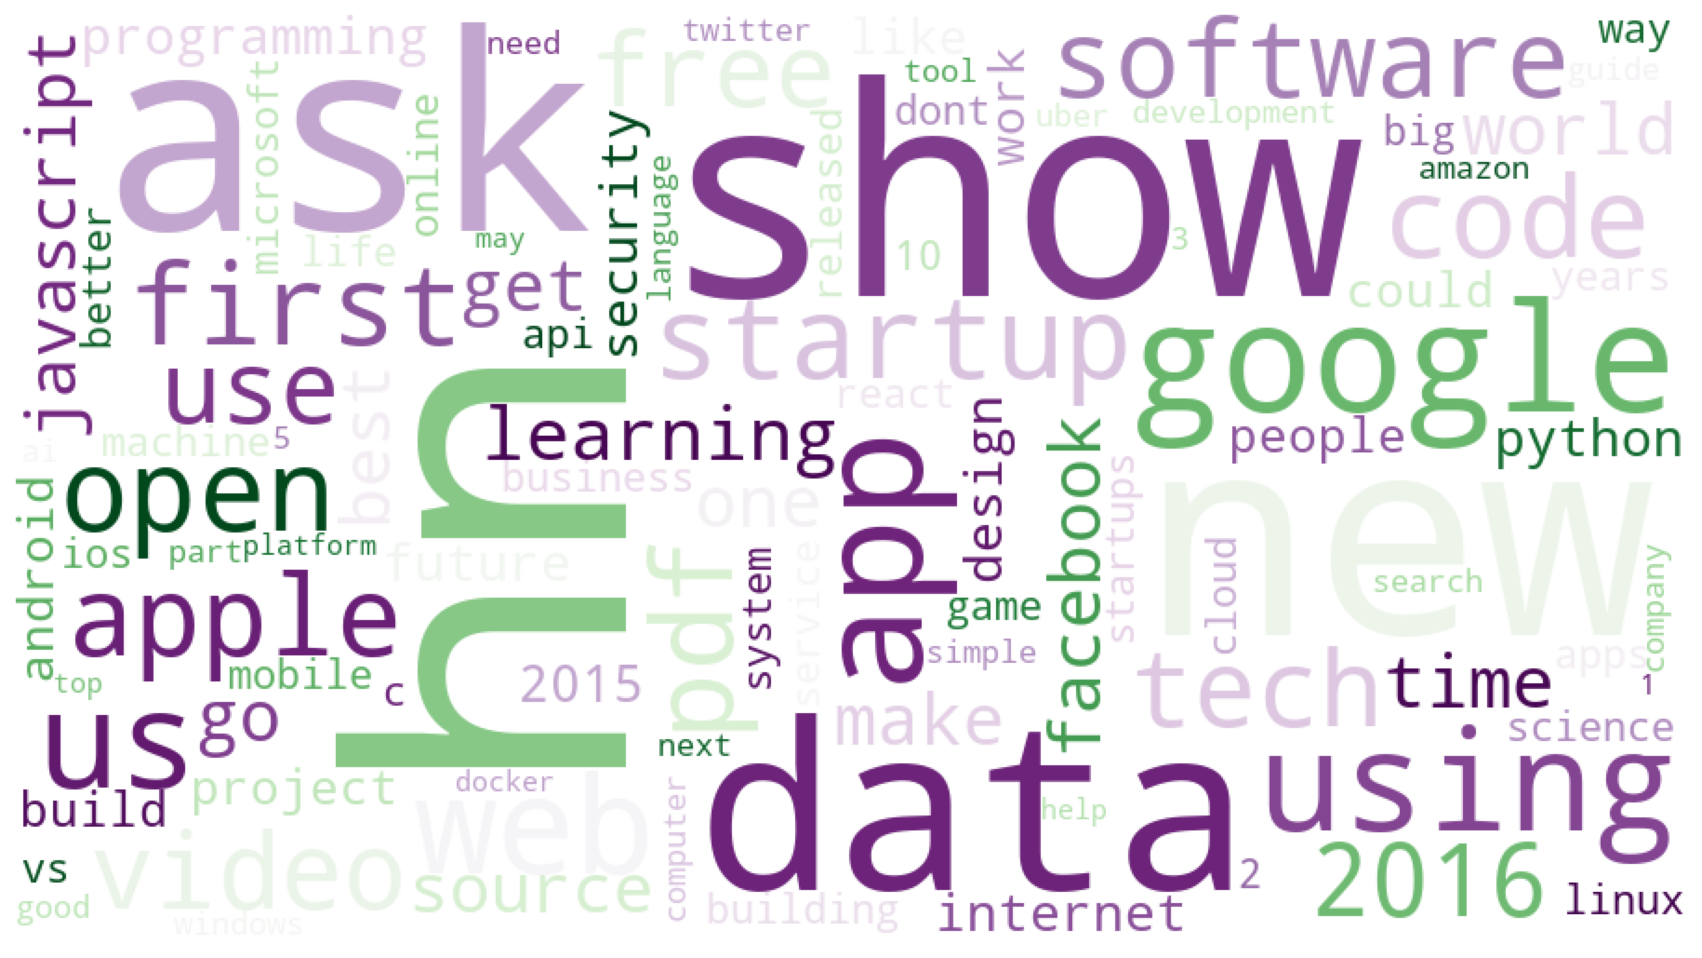

In [53]:
wcdraw(df, 'PRGn')